# Introduction to Notebook 
This is a first attempt at using PyTorch to predict stock prices. In this notebook, I will be using a Linear Regression model, using the previous' day closing price, and RSI, and 50 day Exponential Moving Average (EMA) using the AlphaVantage API. 

### Rationale:
There are too many factors and techniques that investors use to predict trends in the market, and it never relies purely on technical indicators. One of the main purposes of the Notebook is not to create a model that is completely accurate, but to practice using PyTorch and basic Machine Learning ideas. However, to try to be as accurate as to not waste effort, I have chosen 3 indicators,
- 14 day RSI
- Closing price for the day prior
- 50 day Exponential Moving Average (EMA)

The main reasons I selected these 3 indicators is that the RSI and EMA help to estimate momentum of a stock. By using the EMA and RSI, the algorithm would also hopefully give more attention to recent stock data. The closing price is used to provide some sort of "foundation" for the EMA and RSI to estimate off of. 

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators


In [1]:
# HELPER FUNCTIONS

# this function will return the data for a given ticker
def get_data_for_ticker(ticker):

    ts = TimeSeries()
    ti = TechIndicators()
    stock_data, stock_meta = ts.get_intraday(symbol=ticker, interval='60min', outputsize='full')
    rsi, rsi_meta = ti.get_rsi(symbol=ticker, interval='60min', time_period=14, series_type='close')

    data_date = [date for date in stock_data.keys()]
    data_date.reverse()

    data_close_price = [float(stock_data[date]['4. close']) for date in stock_data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    rsi_dates = ["{}:00".format(date) for date in rsi.keys()]
    rsi_dates.reverse()

    rsi_vals = [float(rsi[date]['RSI']) for date in rsi.keys()]
    rsi_vals.reverse()
    rsi_vals = np.array(rsi_vals)

    sim_dates = [date for date in rsi_dates if date in data_date]

    for i in range(len(data_date)):
        if data_date[i] not in sim_dates:
            data_close_price = np.delete(data_close_price, i)

    return sim_dates, data_close_price, rsi_vals

def fix_data_to_50EMA(dates, closing, rsi):
    ti = TechIndicators()
    fty_ema, meta_ema = ti.get_ema(symbol="AAPL", interval='60min', time_period=50, series_type='close')

    ema_dates = ["{}:00".format(date) for date in fty_ema.keys()]
    ema_dates.reverse()

    ema_val = [float(ema[date]['EMA']) for date in fty_ema.keys()]
    ema_val.reverse()
    ema_val = np.array(ema_val)

    idx_to_remove = [i for i in range(len(dates)) if dates[i] not in ema_dates]

    dates = np.array(dates)
    dates = np.delete(dates, idx_to_remove)

    closing = np.array(closing)
    closing = np.delete(closing, idx_to_remove)

    rsi = np.array(rsi)
    rsi = np.delete(rsi, idx_to_remove)

    return dates, closing, rsi, ema_val

def prepare_data_for_ticker(ticker):

    dates, closing, rsi = get_data_for_ticker(ticker)
    dates, closing, rsi, ema_val = fix_data_to_50EMA(dates, closing, rsi)

    ylabel = closing[1:]
    x_date = date[:-1]
    x_closing = closing[:-1]
    x_ema50 = ema50[:-1]

    # Converting to pyTorch tensors
    y_label = y_label.clone().detach()
    y_label = torch.reshape(y_label, (len(y_label), 1))
    x_closing = x_closing.clone().detach().requires_grad_(True)
    x_ema50 = x_ema50.clone().detach().requires_grad_(True)

    # Stacking tensors to create 1 input tensor
    input_x = torch.stack((x_closing, x_ema50), 1)

    train_ds = TensorDataset(input_x, y_label)

    train_dl = DataLoader(train_ds, batch_size=5, shuffle=False)

    return train_dl

In [3]:
ticker = 'AAPL'
dates, data, rsi = get_data_for_ticker(ticker)

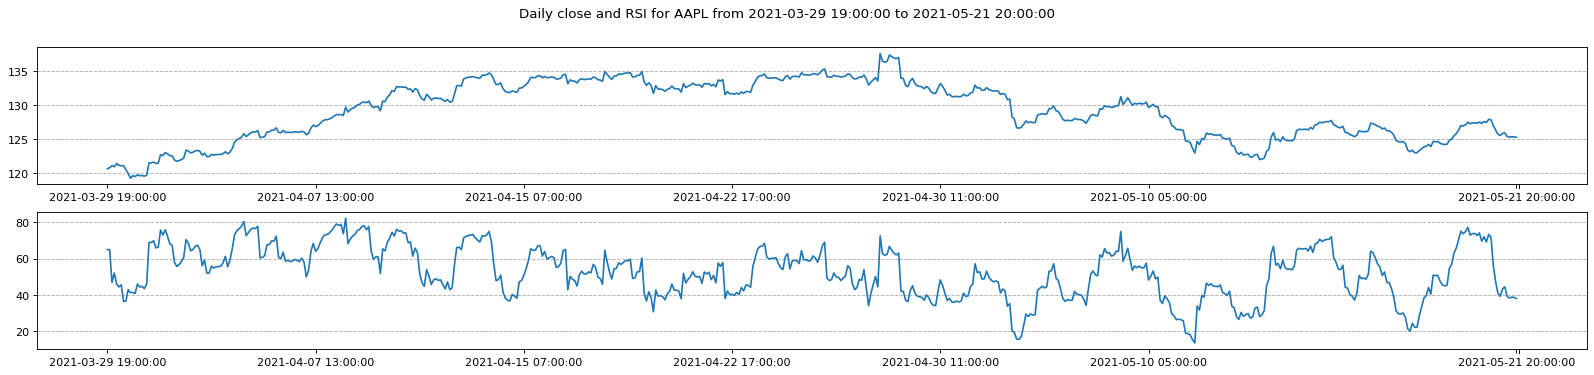

In [6]:
## plot the graphs
fig , (stock_graph, rsi_graph) = plt.subplots(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))
fig.suptitle("Daily close and RSI for {} from {} to {}".format(ticker, dates[0], dates[-1]))

stock_graph.plot(dates, data, label='Closing price')
rsi_graph.plot(dates, rsi, label='rsi')

xticks = [dates[i] if ((i%90 == 0 and (len(dates) - i) > 90) or i == (len(dates) - 1)) else "" for i in range(len(dates))]
x = np.arange(0,len(xticks))

stock_graph.set_xticks(xticks)
rsi_graph.set_xticks(xticks)

stock_graph.grid(b=None, which='major', axis='y', linestyle='--')

rsi_graph.grid(b=None, which='major', axis='y', linestyle='--')

plt.show()


In [36]:
date, closing, rsi, ema50 = fix_data_to_50EMA(dates, data, rsi)

# Preparing/cleaning data to ensure the correct dimensions and that we are using the right data.
The y_label will be the closing price for the next day, so x_date\[i\], x_closing\[i\], x_ema50\[i\] will be used to estimate closing\[i+1\] <==> y_label\[i\]

In [2]:
y_label = closing[1:]
x_date = date[:-1]
x_closing = closing[:-1]
x_ema50 = ema50[:-1]

NameError: name 'closing' is not defined

In [142]:
# Converting to pyTorch tensors
y_label = y_label.clone().detach()
y_label = torch.reshape(y_label, (len(y_label), 1))
x_closing = x_closing.clone().detach().requires_grad_(True)
x_ema50 = x_ema50.clone().detach().requires_grad_(True)

# Stacking tensors to create 1 input tensor
input_x = torch.stack((x_closing, x_ema50), 1)

# Starting the build the neural network (Linear Regression)
The optimizer, loss function and model will be imported from pytorch
- Loss function: Mean squared error
- Optimizer: Stochastic Gradient Descent 


In [156]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

def train(epochs, model, loss_fn, optimizer, train_data):
    for e in range(epochs):
        for xb, yb in train_data:
            pred = model(xb.float())
            loss = loss_fn(pred, yb.float())
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

        if (e + 1) % 10 ==0 :
            print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1,epochs, loss.item()))

train_ds = TensorDataset(input_x, y_label)

train_dl = DataLoader(train_ds, batch_size=5, shuffle=False)

model = nn.Linear(2,1)
loss_fn = F.mse_loss
opt = torch.optim.SGD(model.parameters(), lr = 1e-5)


# Model Pre-trained result

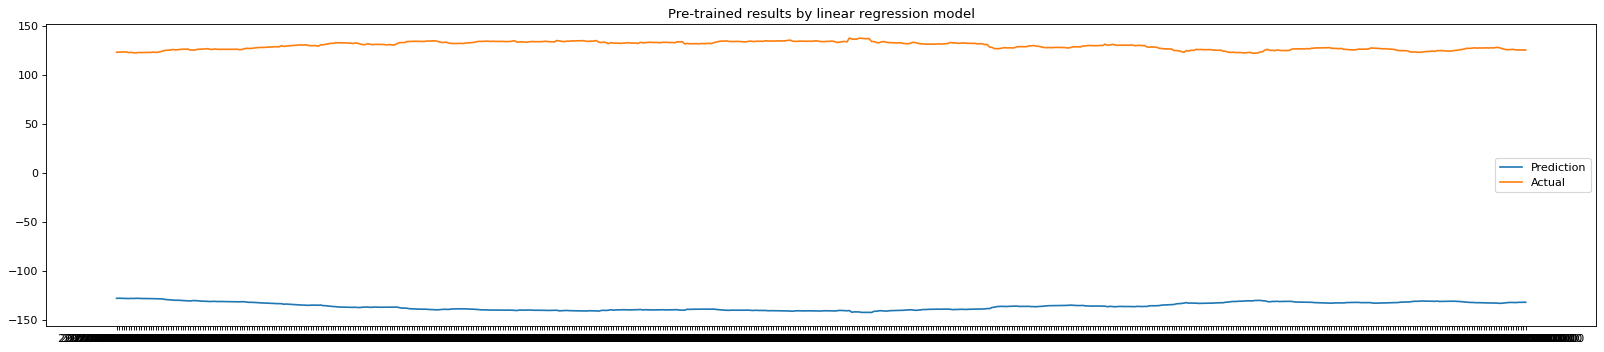

In [161]:
pre_train_result = model(input_x.float())

## plot the graphs
fig= plt.figure(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(x_date, pre_train_result.detach().numpy())
plt.plot(x_date, y_label)

plt.legend(['Prediction', "Actual"])

xticks = [dates[i] if ((i%90 == 0 and (len(dates) - i) > 90) or i == (len(dates) - 1)) else "" for i in range(len(dates))]
x = np.arange(0,len(xticks))

plt.title('Pre-trained results by linear regression model')
plt.show()

# Training the model

In [162]:
train(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 0.0664
Epoch [20/100], Loss: 0.0657
Epoch [30/100], Loss: 0.0650
Epoch [40/100], Loss: 0.0643
Epoch [50/100], Loss: 0.0637
Epoch [60/100], Loss: 0.0630
Epoch [70/100], Loss: 0.0624
Epoch [80/100], Loss: 0.0618
Epoch [90/100], Loss: 0.0611
Epoch [100/100], Loss: 0.0605


# Post train result

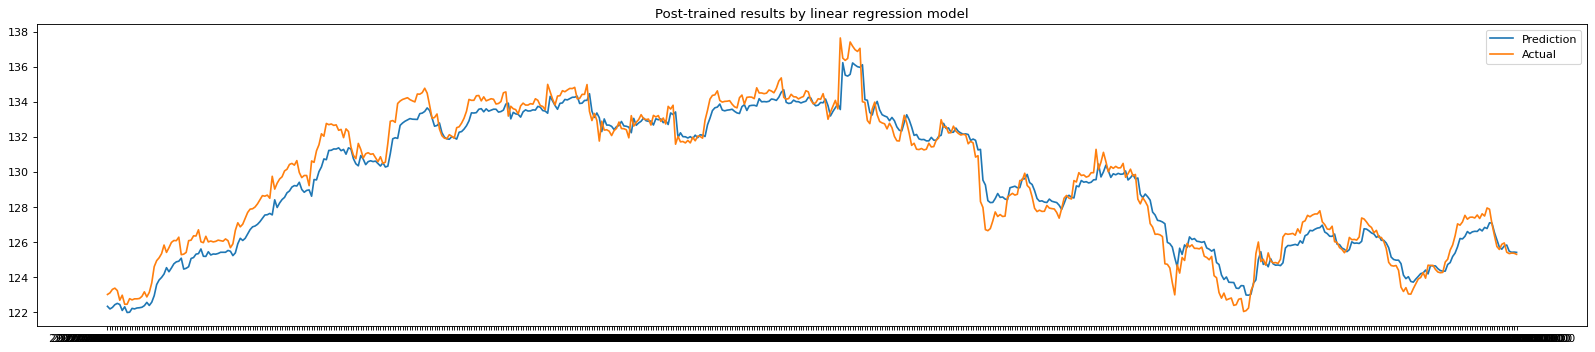

In [163]:
new_pred = model(input_x.float())

## plot the graphs
fig= plt.figure(2, figsize=(25,5), dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(x_date, new_pred.detach().numpy())
plt.plot(x_date, y_label)

plt.legend(['Prediction', "Actual"])

xticks = [dates[i] if ((i%90 == 0 and (len(dates) - i) > 90) or i == (len(dates) - 1)) else "" for i in range(len(dates))]
x = np.arange(0,len(xticks))

plt.title('Post-trained results by linear regression model')
plt.show()

# Testing the model against other tickers

In [167]:
training_data = prepare_data_for_ticker('AAPL')
print(training_data)

ValueError: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.